In [ ]:
# As we use our own external modules, we need the folder src to be in the PYTHONPATH env variable.
# However we do not expect the reader to add that folder to the env variable,
# therefore we manually load it temporarily in each notebook.
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from scipy import stats
import datetime
import h3
import folium

from modules.map_visualization import choropleth_map
from modules.config import PATH_TRIPS, PATH_DIR_FIGURES, PATH_FLEET_SIZE, PATH_SPEEDS

# Descriptive Analysis

Before we start to prepare the dataset for our model, we will analyze it to get a better understanding and also find reasons for our model.

In [ ]:
os.makedirs(PATH_DIR_FIGURES, exist_ok=True)

First we read the prepared data from disk. We use pickle as a format to preserve the data types.

In [ ]:
trips = pd.read_pickle(PATH_TRIPS)

## Examine Short Trips

In [ ]:
print(f"""Percentage of trips with a distance smaller than 100m: \
{len(trips[trips['distance'] < 100]) / len(trips)*100:.4f}%""")

Percentage of trips with a distance smaller than 100m: 7.2010%


As we can see a significant amount of trips (~7%) have a extremely small travel distance.  
This could be due to the fact that trip distance is measured as the distance between the start and the endpoint. Therefore the distance of round trips is close to 0.  
As our model takes into account round trip there is no need to remove these kind of trips.

## Vehicle Types & Providers

In [ ]:
vehicle_types_count = trips['vehicleType'].value_counts()
t_values = list(vehicle_types_count.values)
t_labels = list(vehicle_types_count.index)

os.makedirs(os.path.dirname(PATH_FLEET_SIZE), exist_ok=True)
trips.groupby('vehicleType')['id'].nunique().to_frame().to_pickle(PATH_FLEET_SIZE)


In [ ]:
provider_count = trips['provider'].value_counts()
p_values = list(provider_count.values)
p_labels = list(provider_count.index)
provider_count

lime        431687
car2go      268333
tier        167902
drivenow     66829
circ         63089
fordpass     41999
driveby      12577
bird          1934
kvb            741
Name: provider, dtype: int64

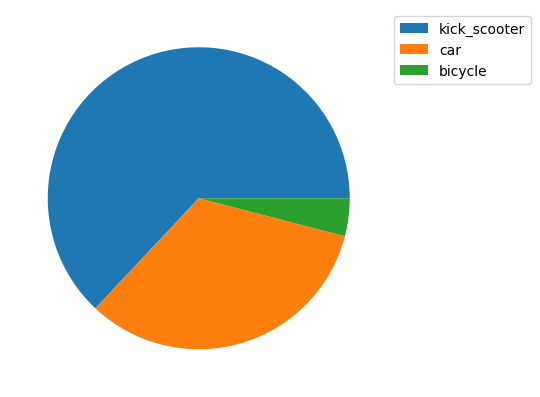

In [ ]:
fig,ax = plt.subplots(figsize=(10,5), dpi= 100, facecolor='white') 

ax.pie(t_values, labels=t_labels, labeldistance=None)
ax.legend(bbox_to_anchor=(1, 1))
plt.savefig(os.path.join(PATH_DIR_FIGURES,'pie_vehicletype.pdf'))
plt.show()

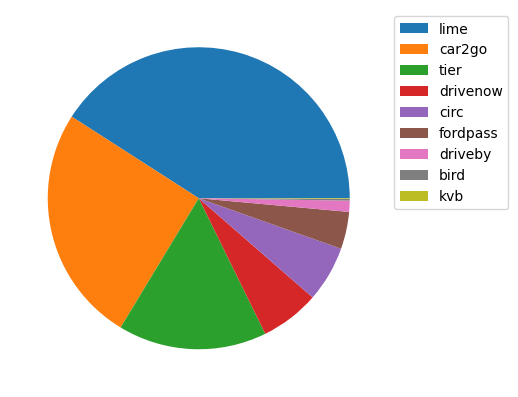

In [ ]:
fig,ax = plt.subplots(figsize=(10,5), dpi= 100, facecolor='white') 

ax.pie(p_values, labels=p_labels, labeldistance=None)
ax.legend(bbox_to_anchor=(1, 1))
plt.savefig(os.path.join(PATH_DIR_FIGURES, 'pie_provider.pdf'))
plt.show()

In [ ]:
vehicle_types_count['bicycle']

42740

As seen above most of our data is kick scooter trips and we only have relatively few bicycle trips.

#### Start distribution (MAYBE DELETE ME)


In [ ]:
trips_start_distribution = trips.groupby('start_hex_id')['id'].count() / len(trips)
trips_start_distribution.sort_values()

start_hex_id
861fa1d67ffffff    9.477855e-07
861fa19a7ffffff    1.895571e-06
861fa1837ffffff    1.895571e-06
861fa19b7ffffff    3.791142e-06
861fa1d4fffffff    1.042564e-05
861fa1897ffffff    5.686713e-05
861fa18afffffff    6.672410e-04
861fa19afffffff    1.028347e-03
861fa189fffffff    1.077632e-03
861fa1817ffffff    1.175254e-03
861fa1d6fffffff    2.117353e-03
861fa188fffffff    2.357143e-03
861fa1887ffffff    3.660348e-03
861fa18a7ffffff    8.518696e-03
861fa1987ffffff    2.643374e-02
861fa1997ffffff    2.678821e-02
861fa199fffffff    3.054808e-02
871fa18a6ffffff    3.185318e-02
871fa18a4ffffff    3.589074e-02
871fa199affffff    4.979950e-02
861fa18b7ffffff    5.558667e-02
861fa198fffffff    5.981759e-02
871fa199dffffff    7.243735e-02
871fa199cffffff    7.526649e-02
871fa199bffffff    1.111591e-01
871fa1998ffffff    1.828913e-01
871fa1999ffffff    2.208501e-01
Name: id, dtype: float64

## Temporal Analysis

In [ ]:
timestamp = trips['datetime_start']

In [ ]:
trips_tsindex = trips.set_index('datetime_start')

In [ ]:
trips_tsindex['id'].resample('D').count()

datetime_start
2019-11-05    17388
2019-11-06        0
2019-11-07        0
2019-11-08        0
2019-11-09        0
              ...  
2020-02-25     4894
2020-02-26     4909
2020-02-27     4894
2020-02-28     5798
2020-02-29     5634
Freq: D, Name: id, Length: 117, dtype: int64

In [ ]:
trips['hour'] = trips['datetime_start'].dt.hour
trips['day'] = trips['datetime_start'].dt.day
trips['yearday'] = trips['datetime_start'].dt.dayofyear
trips['weekday'] = trips['datetime_start'].dt.weekday

In [ ]:
trips_daily = trips_tsindex["id"].resample("W").count()
trips_daily_index = list(
    map(
        lambda datetime: pd.to_datetime(str(datetime)).strftime("%d.%m.%Y"),
        trips_daily.index.values,
    )
)


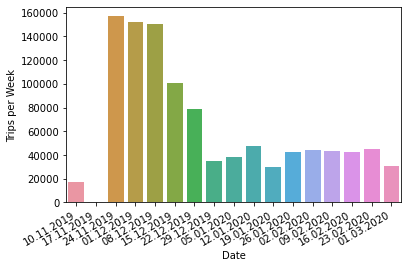

In [ ]:
fig, ax = plt.subplots(1, 1)

sns.barplot(x=trips_daily_index, y=trips_daily.values, ax=ax)
fig.autofmt_xdate()
ax.set_xlabel("Date")
ax.set_ylabel("Trips per Week")
plt.savefig(os.path.join(PATH_DIR_FIGURES, 'trips_weekly.pdf'), bbox_inches="tight")

plt.show()

In [ ]:
trips_december = trips[(trips['datetime_start'] < datetime.datetime(2020, 1, 1)) & 
                       (trips['datetime_start'] > datetime.datetime(2019, 12, 1))]

In [ ]:
print(f"""Percentage of trips within december: \
{len(trips_december) / len(trips)*100:.4f}%""")

Percentage of trips within december: 37.7820%


In [ ]:
print(f"""First trip: {trips['datetime_start'].sort_values(ascending=True).iloc[0]}
Last trip {trips['datetime_start'].sort_values(ascending=False).iloc[0]}""")

First trip: 2019-11-05 10:59:09
Last trip 2020-02-29 23:49:06


Our data lies between November and February with ~38% of it in december. In these months it is mostly cold, which could impact the amount of trips. For a more general prediction of demand one should consider using data from at least a whole year.

In [ ]:
trips_by_weekday = trips.groupby(['weekday', 'vehicleType'])['id'].count()

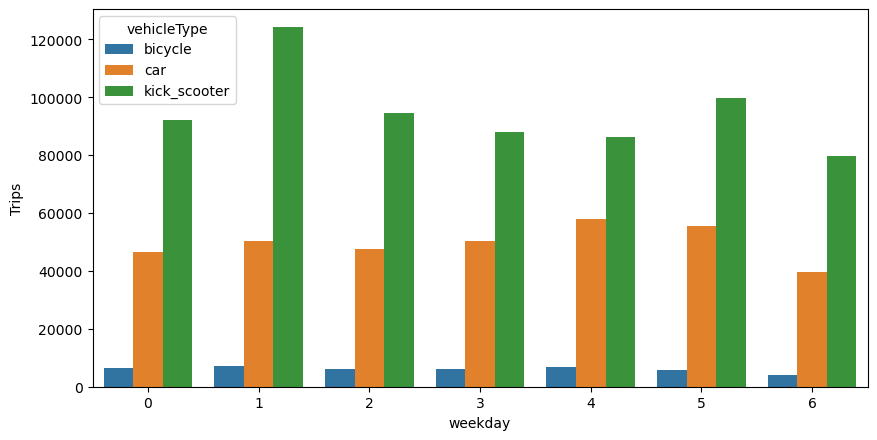

In [ ]:
fig,ax = plt.subplots(figsize=(10,5), dpi=100)

sns.barplot(data = pd.DataFrame(trips_by_weekday).reset_index(), x='weekday', y='id', hue='vehicleType')
ax.set(ylabel='Trips')
plt.savefig(os.path.join(PATH_DIR_FIGURES, 'trips_per_weekday.pdf'))
plt.show()

In [ ]:
trips_by_hour = trips.groupby(['hour', 'vehicleType'])['id'].count()

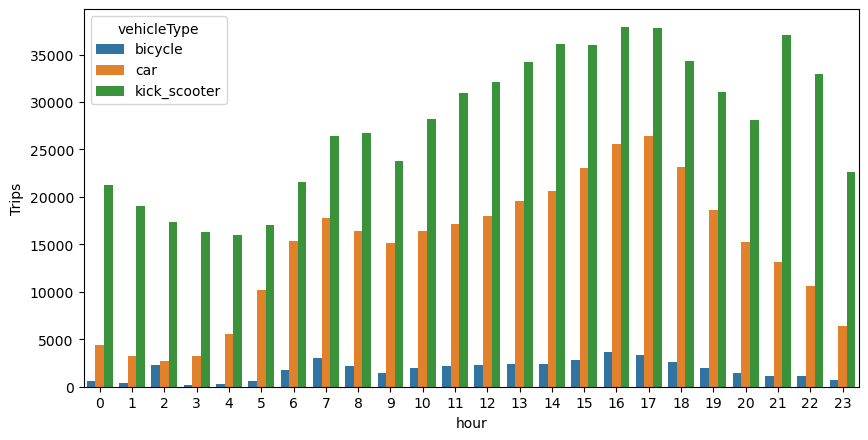

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

sns.barplot(
    data=pd.DataFrame(trips_by_hour).reset_index(),
    x="hour",
    y="id",
    hue="vehicleType",
    ax=ax,
)
ax.set(ylabel="Trips")
plt.savefig(os.path.join(PATH_DIR_FIGURES, "trips_hourly.pdf"))
plt.show()


We can see that for every vehicle type there is a peak in demand at around 08:00 and 17:00. This might also be because of working times. For scooters we do also see a peak in demand at 21:00. This might be because scooters are used for out of work activities.

### Vehicle Usages Per Vehicle Per Day

In [ ]:
trips['date'] = trips['datetime_start'].dt.date
trips_per_day = trips.groupby(['vehicleType', 'id', 'date']).size().to_frame('n_trips')

In [ ]:
trips_per_day.reset_index().groupby('vehicleType')['n_trips'].agg(['mean', 'max', 'min'])

,mean,max,min
vehicleType,,,
bicycle,1.443383,9,1
car,4.600818,19,1
kick_scooter,4.187983,178,1


In [ ]:
trips_per_day['n_trips'].mean()

3.998253046747105

Note that the above mean is taken over all vehicles (per day) that are lent for at least one time that day. So if vehicle x is not lent at date t, then this is not taken into account. However this statistic still gives us information about how many time periods we need per.

However the statistic should be used with caution, as some entries seem unplausible.  
E.g. the kick scooter that was used 178 times on a day.

In [ ]:
inspect = trips[(trips['id'] == 'YmlrZTo6bGltZTo6WFhYLUFCSw==') & (trips['date'] == datetime.date(2019, 12, 11))]
inspect[['datetime_start','datetime_end']]

,datetime_start,datetime_end
2475,2019-12-11 00:10:55,2019-12-11 00:14:11
2476,2019-12-11 00:14:11,2019-12-11 00:19:07
2477,2019-12-11 00:19:07,2019-12-11 00:24:25
2478,2019-12-11 00:24:25,2019-12-11 00:29:09
2479,2019-12-11 00:49:06,2019-12-11 00:54:08
...,...,...
2648,2019-12-11 22:44:08,2019-12-11 22:49:10
2649,2019-12-11 23:20:14,2019-12-11 23:24:26
2650,2019-12-11 23:24:26,2019-12-11 23:29:08
2651,2019-12-11 23:54:07,2019-12-11 23:59:08


In [ ]:
points = inspect.sort_values('datetime_start')[['start', 'end']].values.flatten()

In [ ]:
print(f"avg speed of {(inspect['distance']/inspect['duration']).mean():.2f} m/s")

avg speed of 7.13 m/s


In [ ]:
fmap = folium.Map(location=(50.94, 6.94), zoom_start=11.5, control_scale=True, max_zoom=20)
folium.PolyLine(points).add_to(fmap)
fmap

## Analysis Of Vehicle Types
### Differences

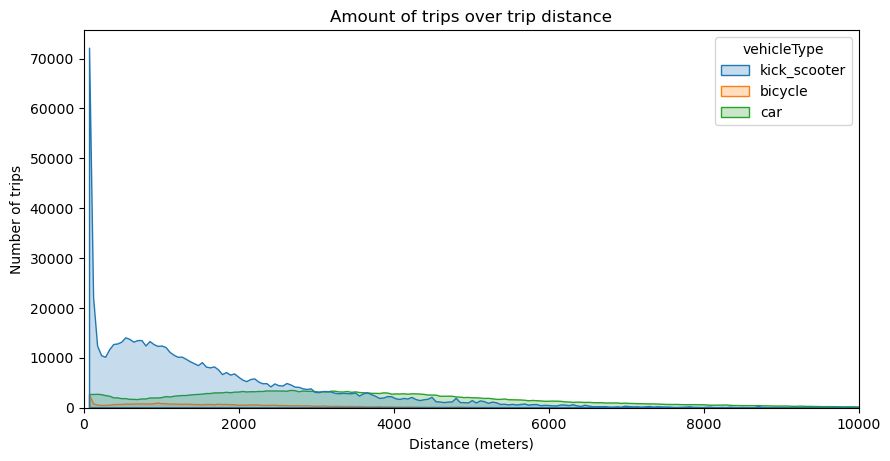

In [ ]:
fig,ax = plt.subplots(figsize=(10,5), dpi=100)

ax = sns.histplot(trips, x='distance', stat='count', hue='vehicleType', element='poly')
ax.set(xlim=(0,10000), xlabel='Distance (meters)', ylabel='Number of trips', title='Amount of trips over trip distance')
plt.savefig(os.path.join(PATH_DIR_FIGURES, 'trips_distance.pdf'))
plt.show()

In [ ]:
trips_split = {}
for v_type in trips['vehicleType'].unique():
    trips_split[v_type] = trips[trips['vehicleType'] == v_type]

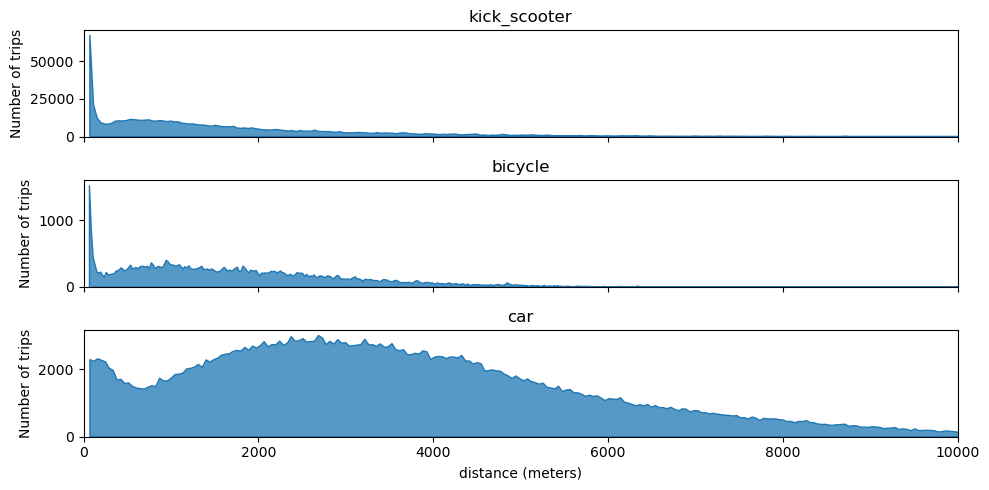

In [ ]:
fig,axes = plt.subplots(figsize=(10,5), nrows=3, sharex=True,dpi=100)

for i, pack in enumerate(trips_split.items()):
    v_type, df = pack
    
    sns.histplot(df, ax=axes[i], bins=500, x='distance', stat='count', element='poly')
    axes[i].set_xlim(0,10000)
    axes[i].title.set_text(v_type)
    axes[i].set_xlabel('distance (meters)')
    axes[i].set_ylabel('Number of trips')
fig.tight_layout()
plt.savefig(os.path.join(PATH_DIR_FIGURES, 'trips_distance_seperated.pdf'))
plt.show()

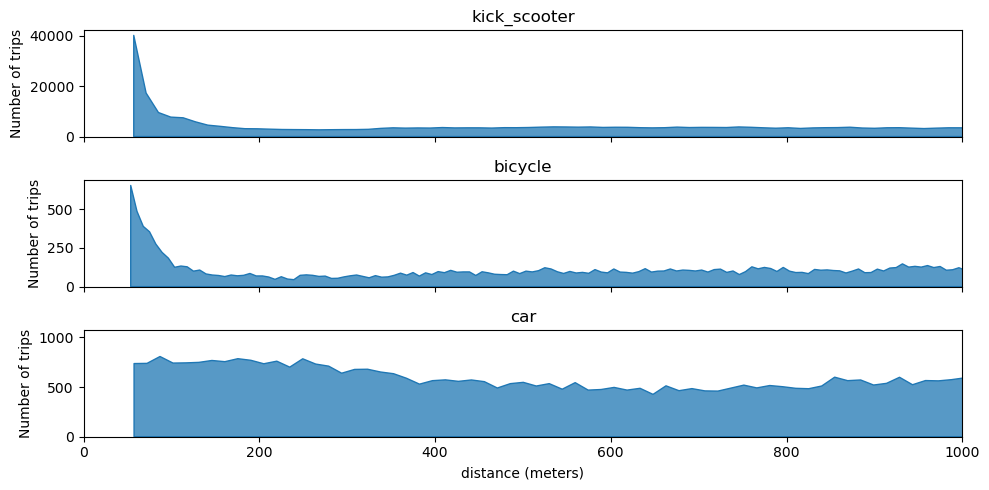

In [ ]:
fig,axes = plt.subplots(figsize=(10,5), nrows=3, sharex=True,dpi=100)

for i, pack in enumerate(trips_split.items()):
    v_type, df = pack
    
    sns.histplot(df, ax=axes[i], bins=1500, x='distance', stat='count', element='poly')
    axes[i].set_xlim(0,1000)
    axes[i].title.set_text(v_type)
    axes[i].set_xlabel('distance (meters)')
    axes[i].set_ylabel('Number of trips')
fig.tight_layout()
plt.savefig(os.path.join(PATH_DIR_FIGURES, 'trips_distance_zoomed.pdf'))
plt.show()

As we can see, in the previous graphs, for kick scooters and bicycles there is a spike right at \~50m trip distance. This is due to round trips. However for cars this spike seems to be significantly smaller. This could because cars distance metric is measured by the car itself and not calculated afterwards by the distance of start and endpoint.  
We can also see that the distribution of trip distances is very similar for kick scooters and bicycles, while trips with cars are usually longer. Cars are not used very often for short trips (~1km). This behaviour is not represented in our model, as we assume that a user would not have any preferences for a specific vehicle type as long as the trip's distances meet the distance limit of the vehicle type.

In [ ]:
trips_car = trips[trips['vehicleType'] == 'car']
trips_scooter = trips[trips['vehicleType'] == 'kick_scooter']
trips_bicycle = trips[trips['vehicleType'] == 'bicycle']

In [ ]:
trips_scooter_non_zero = trips_scooter[trips_scooter['duration'] != 0.0]

In [ ]:
test_car_scooter = stats.ttest_ind(trips_car['distance'].values, trips_scooter['distance'].values)
test_bicycle_scooter = stats.ttest_ind(trips_bicycle['distance'].values, trips_scooter['distance'].values)
test_car_bicycle = stats.ttest_ind(trips_car['distance'].values, trips_bicycle['distance'].values)

In [ ]:
print(f"""mean distance of car trips vs. mean distance scooter trips
{test_car_scooter.statistic} {test_car_scooter.pvalue}

mean distance of car trips vs. mean distance bicycle trips
{test_car_bicycle.statistic} {test_car_bicycle.pvalue}

mean distance of bicycle trips vs. mean distance scooter trips
{test_bicycle_scooter.statistic} {test_bicycle_scooter.pvalue}
""")

mean distance of car trips vs. mean distance scooter trips
516.012779800204 0.0

mean distance of car trips vs. mean distance bicycle trips
156.3512018566703 0.0

mean distance of bicycle trips vs. mean distance scooter trips
19.947292367559676 1.6737800564241688e-88



As we can see the mean distance of car trips is statistically significantly larger than the mean distance of bicycle and scooter trips.

### Speed (for profit & cost calculation)

In [ ]:
car_speed = (trips_car['distance'] / trips_car['duration']).mean()
scooter_speed = (trips_scooter_non_zero['distance'] / trips_scooter_non_zero['duration']).mean()
bicycle_speed = (trips_bicycle['distance'] / trips_bicycle['duration']).mean()

In [ ]:
print(f"""average speed of car trips: 
~{car_speed:.2f} m/s
~{car_speed /1000 * 60:.4f} km/min

average speed of scooter trips: 
~{scooter_speed:.2f} m/s
~{scooter_speed /1000 * 60:.4f} km/min

average speed of bicycle trips: 
~{bicycle_speed:.2f} m/s
~{bicycle_speed /1000 * 60:.4f} km/min
""")

average speed of car trips: 
~1.86 m/s
~0.1117 km/min

average speed of scooter trips: 
~3.74 m/s
~0.2244 km/min

average speed of bicycle trips: 
~0.83 m/s
~0.0497 km/min



In [ ]:
speeds = pd.DataFrame(
    index=["car", "bicycle", "kick_scooter"],
    data=(
        map(lambda speed: speed / 1000 * 60, [car_speed, bicycle_speed, scooter_speed])
    ),
).rename(columns={0: "speed (km/min)"})

os.makedirs(os.path.dirname(PATH_SPEEDS), exist_ok=True)
speeds.to_pickle(PATH_SPEEDS)
speeds


,speed (km/min)
car,0.111651
bicycle,0.049674
kick_scooter,0.224389


## Visualization Of Spatial Imbalances

In [ ]:
trips_morning = trips[(trips['hour'] < 12)]
trips_evening = trips[(trips['hour'] >= 12)]

trips_grouped_start_morning = trips_morning.groupby("start_hex_id").size().to_frame("start")
trips_grouped_end_morning = trips_morning.groupby("end_hex_id").size().to_frame("end")
trips_grouped_start_evening = trips_evening.groupby("start_hex_id").size().to_frame("start")
trips_grouped_end_evening = trips_evening.groupby("end_hex_id").size().to_frame("end")

trips_grouped_morning = trips_grouped_start_morning.merge(
    trips_grouped_end_morning, left_index=True, right_index=True, how="outer"
).fillna(0)
trips_grouped_evening = trips_grouped_start_evening.merge(
    trips_grouped_end_evening, left_index=True, right_index=True, how="outer"
).fillna(0)
trips_grouped = trips_grouped_evening.merge(trips_grouped_morning, left_index=True, right_index=True, how="outer", suffixes=("_evening", "_morning")).fillna(0)

trips_grouped["boundaries"] = trips_grouped.index.map(
    lambda hex: {
        "type": "Polygon",
        "coordinates": [h3.h3_to_geo_boundary(hex, geo_json=True)],
    }
)
trips_grouped = trips_grouped.reset_index().rename(columns={'index': 'hex_id'})
trips_grouped.head(3)

,hex_id,start_evening,end_evening,start_morning,end_morning,boundaries
0,861fa1817ffffff,931.0,422.0,309.0,790.0,"{'type': 'Polygon', 'coordinates': [((7.041091..."
1,861fa1837ffffff,2.0,2.0,0.0,1.0,"{'type': 'Polygon', 'coordinates': [((7.015981..."
2,861fa1887ffffff,2464.0,2335.0,1398.0,1540.0,"{'type': 'Polygon', 'coordinates': [((7.005262..."


In [ ]:
trips_grouped["diff_evening"] = trips_grouped["end_evening"] - trips_grouped["start_evening"]
trips_grouped["diff_morning"] = trips_grouped["end_morning"] - trips_grouped["start_morning"]
trips_grouped["diff_total"] = trips_grouped["diff_morning"] + trips_grouped["diff_evening"]

trips_grouped["sum_evening"] = trips_grouped["end_evening"] + trips_grouped["start_evening"]
trips_grouped["sum_morning"] = trips_grouped["end_morning"] + trips_grouped["start_morning"]
trips_grouped["sum_total"] = trips_grouped["sum_morning"] + trips_grouped["sum_evening"]


trips_grouped.head(3)


,hex_id,start_evening,end_evening,start_morning,end_morning,boundaries,diff_evening,diff_morning,diff_total,sum_evening,sum_morning,sum_total
0,861fa1817ffffff,931.0,422.0,309.0,790.0,"{'type': 'Polygon', 'coordinates': [((7.041091...",-509.0,481.0,-28.0,1353.0,1099.0,2452.0
1,861fa1837ffffff,2.0,2.0,0.0,1.0,"{'type': 'Polygon', 'coordinates': [((7.015981...",0.0,1.0,1.0,4.0,1.0,5.0
2,861fa1887ffffff,2464.0,2335.0,1398.0,1540.0,"{'type': 'Polygon', 'coordinates': [((7.005262...",-129.0,142.0,13.0,4799.0,2938.0,7737.0


In [ ]:
dfmap = choropleth_map(
    trips_grouped,
    id_field="hex_id",
    geometry_field="boundaries",
    value_field="diff_morning",
    with_legend=True,
    kind="zero_center"
)
dfmap


In [ ]:
dfmap = choropleth_map(
    trips_grouped,
    id_field="hex_id",
    geometry_field="boundaries",
    value_field="diff_evening",
    with_legend=True,
    kind="zero_center"
)
dfmap


The map visualizes the difference between the number of trips ending in a region and the number of trips starting in a region. A region with a negative difference, which means that more trips start in this region than trips end there, is colored red. A negative difference leads to a shortage of vehicles and, therefore, to unmet demand.
A region with a positive difference, which means that more trips end in this region than trips start there, is colored green. A positive difference leads to unused vehicles and, therefore, a waste of resources.
We can interpret these differences as a change in the system's balance.
The first map only accounts for trips between 12:00 and 24:00 and the second map only accounts for trips between 00:00 and 12:00.  
Between 00:00 and 12:00 there are a few regions with more inbound trips than outgoing trips. These regions are mainly business areas and the city's center. Residential areas mostly have more outgoing trips than inbound. This behavior is most likely due to people going to work and it shows that the system's balance changes between 00:00 and 12:00. Therefore either before or after this period the system has to be imbalanced.  
For the period between 12:00 and 00:00 the balance changes are reverted. There are more outgoing trips from the city's center and business areas than there are ingoing. Also there are more inbound trips in resedential areas than there are outgoing. This is most likely due to people going home after work. Therefore balance changes also occur in this period, which means that there has to be an imbalance before or after the period.  
One might argue that the balance changes in these two periods equalize one another, however as the next map shows that does not seem to be the case.

In [ ]:
dfmap = choropleth_map(
    trips_grouped,
    id_field="hex_id",
    geometry_field="boundaries",
    value_field="diff_total",
    with_legend=True,
    kind="zero_center"
)
dfmap


Eventhough these balance changes are a lot less than the balance changes that happen over the course of a day, we see that they even occur long term.  
So there are short term imbalances during each day and long term imbalances. This shows the importance of vehicle relocations.

In [ ]:
dfmap = choropleth_map(
    trips_grouped,
    id_field="hex_id",
    geometry_field="boundaries",
    value_field="sum_total",
    with_legend=True,
    kind="linear"
)
dfmap
